<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h5 style="color:#C0C0C0">LMU, 08 August 2019</h5>
    <h4 style="color:rgba(0,0,0,0.6)">Sebastian Anger, Tobias Megies, Taufiqurrahman, Alice Gabriel</h4>
    </div>
    <div style="float:right; margin: 20px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 100px">
        <div style="position:relative; top:40%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P08 - Filters II</div>
        </div>
    </div>
   
</div>

**Please, do not forget to execute the Cell 1 first!**

In [1]:
# Cell 1: Preparation for programming
%pylab inline
from __future__ import print_function
from scipy import interpolate, signal
from time import *
from obspy import *
import numpy as np
import matplotlib.pylab as plt
import os
import glob
from obspy.core.utcdatetime import UTCDateTime 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5

Populating the interactive namespace from numpy and matplotlib


## Exercise 1: Bird Song 


In this exercise you will plot a fourier transform of a Nightingale song. You will change the window length of the sliding window used by the spectrogram function to illustrate the uncertainty principle. You can compare the effect of different window lengths in the plot easily by setting NFFT and NFFT2 to two different values. In the spectrogram plots, reds and yellows represent frequencies and times at which more energy is present in the signal. 

Listen to the file 'DATA/Luscinia.megarhynchos.wav'. Thank you to the website  http://www.scricciolo.com/eurosongs/canti.htm for providing this file. 

Run Cell 1a. Then answer the questions with the code in Cell 1b. 

1a) set NFFT to a smaller value and run the cell again. Incrementally reduce to values around about 120 points. Describe what happens. 

1b) set NFFT2 to a larger value (up to around 3000 points) and run the cell again. Describe what happens. 

1c) Which values of NFFT/NFFT2 are best to determine the individidual notes? Listen to the file again and check that you can see the individual notes. Which values are best to determine the notes for the whole piece? 


In [2]:
# Cell 1a: Read in a .wav file of a Nightingale song

import wave
import struct

# read in the file 
stream = wave.open('DATA/Luscinia.megarhynchos.wav','r')

# get the details about the .wav file
num_channels = stream.getnchannels()
frame_rate = stream.getframerate()
sample_width = stream.getsampwidth()
num_frames = stream.getnframes()
total_samples = num_frames * num_channels
endtime = float(total_samples) / float(frame_rate)

# read the byte data
raw_data = stream.readframes( num_frames )
stream.close()

# check the type of audio track
if sample_width == 1: 
    fmt = "%iB" % total_samples # read unsigned chars
elif sample_width == 2:
    fmt = "%ih" % total_samples # read signed 2 byte shorts
else:
    raise ValueError("Only supports 8 and 16 bit audio formats.")

# unpack the byte data to integers
integer_data = struct.unpack(fmt, raw_data)

# Keep memory tidy
del raw_data

# set up the channel
channels = [ [] for time in range(num_channels) ]

# read the integers to channels
for index, value in enumerate(integer_data):
    bucket = index % num_channels    
    channels[bucket].append(value)
    
print('No of records in the channel:', len(channels[0]))


No of records in the channel: 128512


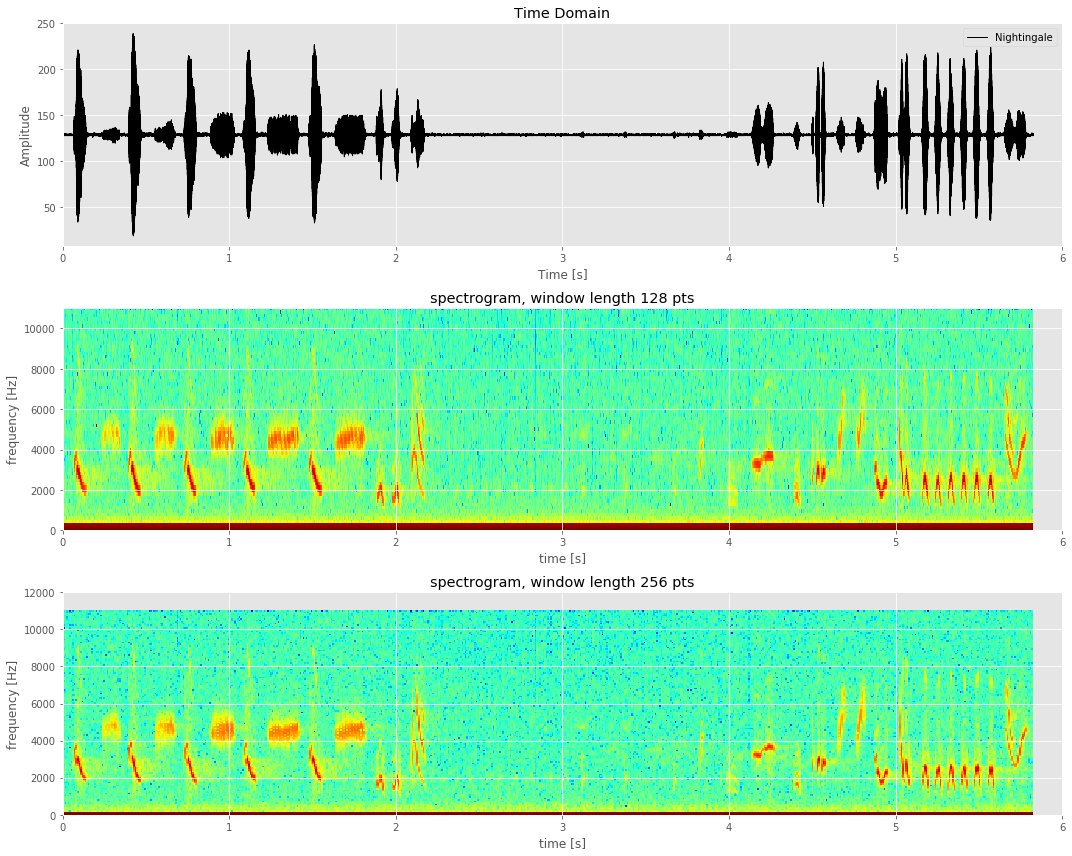

In [3]:
# Cell 1a: View the Nightingale song in the frequency domain

NFFT = 128     # length of spectrogram window in sample points, version 1, originally 256
NFFT2 = 256    # length of spectrogram window, version 2, originally 256
noverlap = 50  # number of sample points that the sliding window overlaps, 
               # must be less than NFFT
noverlap2 = 50 # number of sample points that the sliding window overlaps, 
               # must be less than NFFT2

plot_freq_min = 0       # the lower frequency bound for the plot, in Hz
plot_freq_max = 12000     # the upper frequency bound for the plot, in Hz

# x axis limits in the plot, in seconds
xstart = 0
xend = 6

# make a time series 
time = np.linspace(0,endtime,total_samples)  # in seconds

plt.figure(figsize=(15,12))

ax1 = plt.subplot(311)
plt.plot(time, channels[0], 'k', label="Nightingale", lw=1)
plt.legend()
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# plt.ylim((plot_freq_min, plot_freq_max))
plt.subplot(312, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
Pxx, freqs, bins, im = plt.specgram(channels[0], NFFT=NFFT, Fs=frame_rate, noverlap=noverlap,
                                cmap=cm.jet,sides='onesided')

# plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')

plt.subplot(313, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT2)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
Pxx, freqs, bins, im = plt.specgram(channels[0], NFFT=NFFT2, Fs=frame_rate, noverlap=noverlap2,
                                cmap=cm.jet,sides='onesided')
plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.xlim((xstart, xend))

# prevent subplots overlapping
plt.tight_layout() 

plt.show()

**Answer:**

Uncertainty principle: shortening the window length will sharpen single (vertical) notes but creates long harmonic oscillations. Increasing then the window length will result in widening the single (vertical) notes but captures the harmonic oscillations more precisely. A good value to determine each note is NFFT = 128.

## Exercise 2: spectrogram of an earthquake 

This exercise is similar to exercise 1, except that we will use data from an earthquake. In this exercise you will change the window length of the sliding window used by the spectrogram function to illustrate the uncertainty principle. You can compare the effect of different window lengths in the plot easily by setting NFFT and NFFT2 to two different values. In the spectrogram plots, reds and yellows represent frequencies and times at which more energy is present in the signal. 

Run Cell 2a. Then answer the questions with the code in Cell 2b. 

2a) set NFFT to a larger value and run the cell again. Incrementally increase to values around about 3000 points. Describe what happens. 

2b) Zoom in to the start of the signal by changing xstart and xend. Does a longer or shorter window length allow you to identify the start of the signal more easily?

2c) Now adapt the time limits to look at the surface waves. Can you see the effect of dispersion? With which window length is this effect clearer? 
Hint: Reduce the visible frequency ranges to between 0 and 0.2 Hz. 


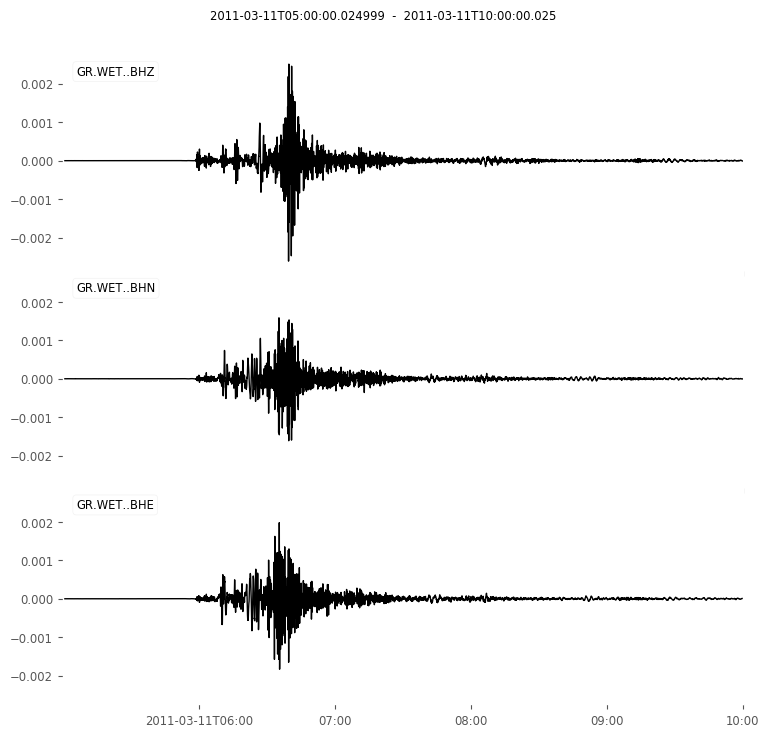

In [4]:
#Cell 2a: prepare data from Tohoku earthquake. 
dataDir = "./DATA/"

# you can use this to trim down the signal to a shorter length if your computer is struggling. However, be aware 
# that you will have to re-run this cell and all others below it if you want to use a longer signal again. 
t1 = UTCDateTime("2011-03-11T05:00:00.000")
t2 = UTCDateTime("2011-03-11T10:00:00.000")

# Tohoku event, recorded in Germany
network1 = "GR"
station1 = "WET"
ch1 = "B*"

stt_orig = Stream()
for filename in glob.glob(dataDir + "/*%s*.mseed" % station1):
    stt_orig += read(filename)
    
# make a copy to keep our original data
stt1 = stt_orig.copy()
# trim the data between time 1 and time 2
stt1.trim(t1,t2)
stt1.plot()

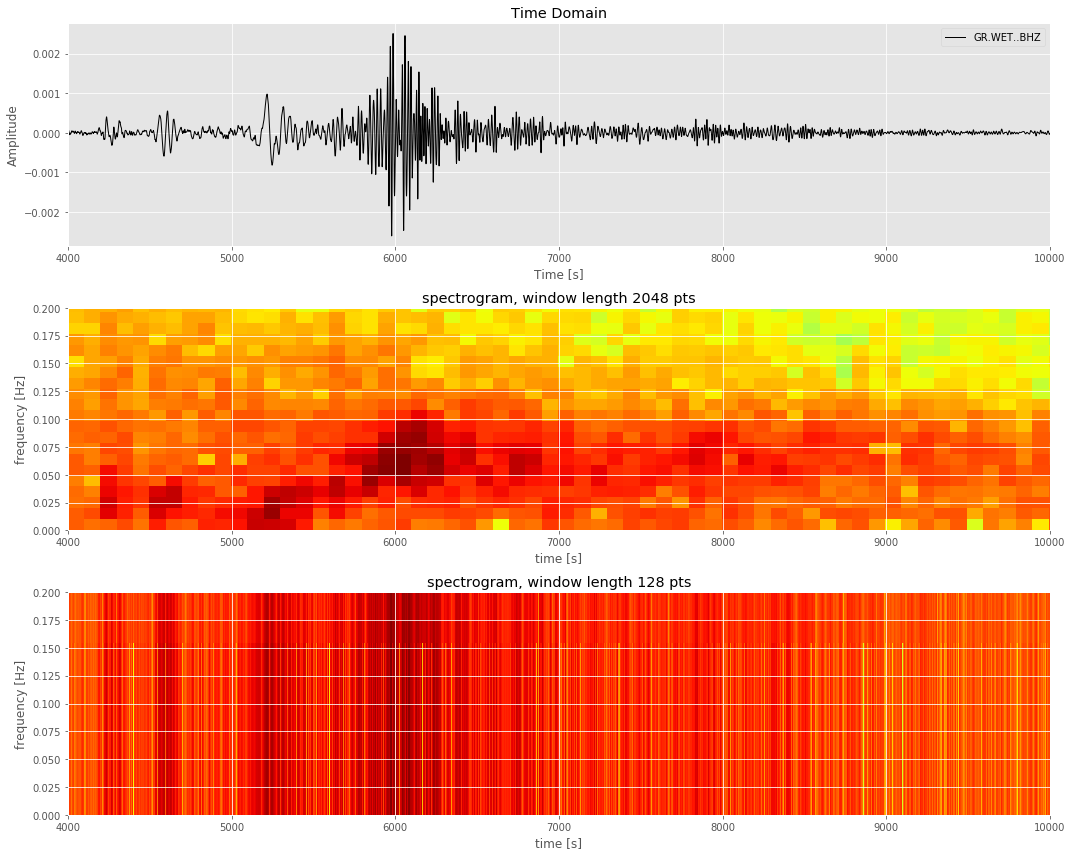

In [5]:
# Cell 2b: Plotting a spectrogram

# we will use data from Cell2a 
# this is from the Tohuku earthquake from the German station  
# we will start with the vertical trace
for trace in stt1:
    if trace.stats.channel == 'BHZ':
        tr = trace.copy()
        
# make a list of times        
time = tr.times()


NFFT = 2048     # length of spectrogram window in sample points, version 1, originally 256
NFFT2 = 128    # length of spectrogram window, version 2, originally 256
noverlap = 50  # number of sample points that the sliding window overlaps, 
               # must be less than NFFT
noverlap2 = 50 # number of sample points that the sliding window overlaps, 
               # must be less than NFFT2
Fs = int(tr.stats.sampling_rate)  # the sampling frequency

plot_freq_min = 0       # the lower frequency bound for the plot, in Hz, originally 0 Hz
plot_freq_max = 0.2      # the upper frequency bound for the plot, in Hz, originally 10 Hz

# x axis limits in the plot, in seconds
xstart = 4000 # originally 0 s 
xend = 10000 # originally 18000 s


plt.figure(figsize=(15,12))

ax1 = plt.subplot(311)
plt.plot(time, tr.data, 'k', label=tr.id, lw=1)
plt.legend()
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
# # plt.ylim((plot_freq_min, plot_freq_max))
plt.subplot(312, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
Pxx, freqs, bins, im = plt.specgram(tr.data, NFFT=NFFT, Fs=Fs, noverlap=noverlap,
                                cmap=cm.jet)

plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')

plt.subplot(313, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT2)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
Pxx, freqs, bins, im = plt.specgram(tr.data, NFFT=NFFT2, Fs=Fs, noverlap=noverlap2,
                                cmap=cm.jet)
plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.xlim((xstart, xend))

# prevent subplots overlapping
plt.tight_layout() 

plt.show()

**Answer:**

With a longer window you can easily see the start of the signal but the start signal is shifted to the left. Therefore, it is not convenient to use large windows for the onset of the signal.
Yes, dispersion is visible. This is the result of different velocities (group vs. phase velocity) for the surface waves. This effect can be seen with a larger window length because then the group velocity of the surface waves are better captured.

## Exercise 3: Downsampling

Here, we learn what happens while downsampling data and what needs to be considered.

Execute the following code:

3a) Write down what happens when we are just taking every second point (red lines). What do we call this effect?

3b) How do you circumvent this problem by filtering (check the frequency representation)?

C:\Users\igel\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


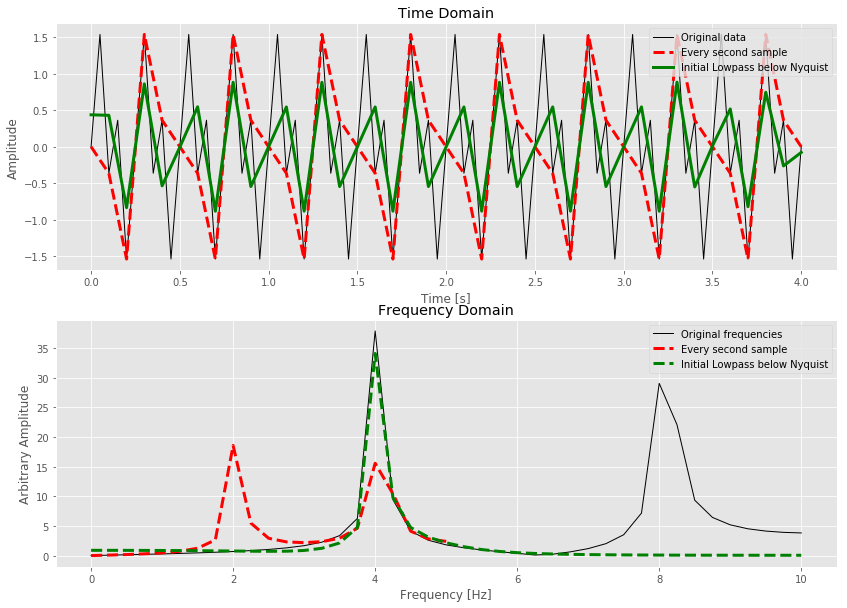

In [6]:
# Cell 3: Downsampling
# -*- coding: utf-8 -*-
# 2009-12-06 Moritz

import numpy as np
from obspy.signal.filter import lowpass

# Number of points
#npts = 64
nsec = 4.0
df = 20.0

# Determine Nyquist and set generator frequency
fmax = df / 2.0 # nyquist
fg1 = 8 # generator frequency I
fg2 = 4 # generator frequency II

# sampling frequency 20 Hz, sampling for 4 s
time = np.linspace(0,nsec,(nsec*df)+1)  # in seconds

# Generate f0 Hz sine wave
y  = np.sin(2 * np.pi * fg1 * time)  #+ np.pi / 5)
y += np.sin(2 * np.pi * fg2 * time)  #+ np.pi / 5)

# Downsample to 10Hz by taking every second element
y_2 = y[::2]

# Downsample after Lowpassing the signal
y_l = lowpass(y, 5.0, df=df, corners=4, zerophase=True)

y_new = y_l[::2]

# Look at result in frequency domain
y_f = np.fft.rfft(y)
y_f2 = np.fft.rfft(y_2)
y_fnew = np.fft.rfft(y_l)
freq = np.linspace(0, fmax, len(y_f))


#
# Plot the whole filtering process
#
plt.figure(figsize=(14, 10))
plt.subplot(211)
plt.plot(time, y, 'k', label="Original data", lw=1)
plt.plot(time[::2], y_2, 'r--', label="Every second sample", lw=3)
plt.plot(time[::2], y_new, 'g', label="Initial Lowpass below Nyquist", lw=3)
plt.legend()
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(freq, abs(y_f), 'k', label="Original frequencies", lw=1)
plt.plot(freq[:len(y_f2)], abs(y_f2), 'r--', label="Every second sample", lw=3)
plt.plot(freq[:len(y_fnew)], abs(y_fnew), 'g--', label="Initial Lowpass below Nyquist", lw=3)
plt.legend()
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary Amplitude')

plt.show()


**Answer: **
This effect is called the Nyquist theorem. Artifical frequencies appear and not all original frequencies can be represented anymore. By applying a low pass filter the artificial frequencies vanish but still the effect of downsampling can be seen. The cut-off frequency must be in the range of [4,8[ Hz.